In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2


from PIL import Image

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

/tmp/ipykernel_7799/632148889.py:5: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  from scipy import ndimage
2025-10-28 11:51:46.670509: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 11:51:46.692034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-28 11:51:46.692051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-28 11:51:46.693167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to regis

#### Experiment #1 : Symmetric Convolution


2025-10-28 11:51:47.540140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-28 11:51:47.575935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-28 11:51:47.576957: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

TensorShape([50, 50])

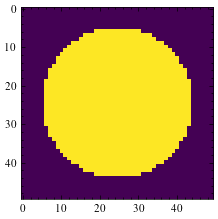

In [2]:
'''img = np.zeros((45, 45))
center_coordinates = (img.shape[0]//2, img.shape[1]//2) 
img = cv2.circle(img, center_coordinates, 20, (255,255,255), -1) 
plt.imshow(img)'''


N = 50
#img =  tf.image.rot90(tf.random.uniform(shape=(50,50,1), minval=0., maxval=1.), k=1) #
#img = tf.image.pad_to_bounding_box(img, 25//2,25//2,N+25, N+25)[...,0]

img =  tf.expand_dims(cv2.imread('input4.png', 0)/255. , axis=-1)
H, W, C = img.shape  # Get image dimensions
offset_height = (H - N) // 2
offset_width = (W - N) // 2
img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]
plt.imshow(img)
img.shape


(50, 50)


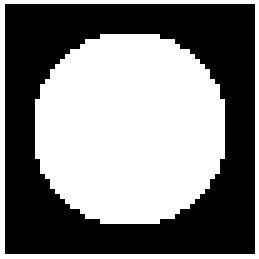

In [3]:
#var = 2/(128*9)

fig,ax = plt.subplots(1)

ax.imshow(img, cmap='gray')

#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("input.png",bbox_inches='tight',   pad_inches = 0)


In [4]:
'''img = np.random.normal(loc=0.0, scale=1.0, size=(500, 500))
print("Original shape:", img.shape)

# Pad with 10 pixels of zeros on all sides
img = np.pad(img, pad_width=((10, 10), (10, 10)), mode='constant', constant_values=0)

fig, ax = plt.subplots()
ax.imshow(img)
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()'''

'img = np.random.normal(loc=0.0, scale=1.0, size=(500, 500))\nprint("Original shape:", img.shape)\n\n# Pad with 10 pixels of zeros on all sides\nimg = np.pad(img, pad_width=((10, 10), (10, 10)), mode=\'constant\', constant_values=0)\n\nfig, ax = plt.subplots()\nax.imshow(img)\nx_min, x_max = 30, 60\ny_min, y_max = 30, 60\n\nax.set_xlim(x_min, x_max)\nax.set_ylim(y_min, y_max)\n\nplt.show()'

Original shape: (500, 500)


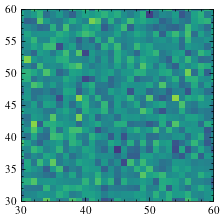

In [5]:
img = np.random.normal(loc=0.0, scale=1.0, size=(500, 500))
print("Original shape:", img.shape)

# Pad with 10 pixels of zeros on all sides
img = np.pad(img, pad_width=((10, 10), (10, 10)), mode='constant', constant_values=0)

fig, ax = plt.subplots()
ax.imshow(img)
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor(1.002009278192873, shape=(), dtype=float64)
tf.Tensor(1.0079809766567134, shape=(), dtype=float64)
tf.Tensor(1.0177504770286105, shape=(), dtype=float64)
tf.Tensor(1.031055435689618, shape=(), dtype=float64)
tf.Tensor(1.0475518465615299, shape=(), dtype=float64)
tf.Tensor(1.066833155159449, shape=(), dtype=float64)
tf.Tensor(1.0884501212539501, shape=(), dtype=float64)
tf.Tensor(1.111929523933396, shape=(), dtype=float64)
tf.Tensor(1.1367904351722251, shape=(), dtype=float64)
tf.Tensor(1.1625574447466513, shape=(), dtype=float64)
tf.Tensor(1.1887707563557135, shape=(), dtype=float64)
tf.Tensor(1.2149934329403305, shape=(), dtype=float64)
tf.Tensor(1.240816254901746, shape=(), dtype=float64)
tf.Tensor(1.2658607087798388, shape=(), dtype=float64)
tf.Tensor(1.2897805943875535, shape=(), dtype=float64)
tf.Tensor(1.3122626666574368, shape=(), dtype=float64)
tf.Tensor(1.3330266433695375, shape=(), dtype=float64)
tf.Tensor(1.3518248285087247, 

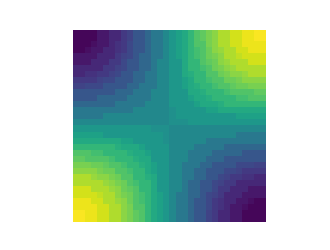

In [6]:

k = 32
w = np.zeros((k,k,1,1))


t1 = np.zeros((k,k))
t2 = np.zeros((k,k))
t3 = np.zeros((k,k))

'''t1[1, 2] = 1.
t2[2, 1] = 1.'''
t1[1,1] = 1.
t2[2, 0] = 1.
t3[0, 2] = 1.


w1 = fft.idctn(t1, norm='ortho')
#w1 /= np.sum(np.abs(w1))

w2 = fft.idctn(t2, norm='ortho') -  fft.idctn(t3, norm='ortho')
#w2 /= np.sum(np.abs(w2))

frames = []
angles = np.linspace(-np.pi, np.pi, 100)

angle0 = np.pi/8


for angle in angles :    
    
    fig, ax = plt.subplots()


    w[:,:,0,0] = (np.cos(angle))*w1 + ( np.sin(angle))*w2
    print(tf.math.reduce_euclidean_norm(w))
    w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


    im = ax.imshow(w[:,:,0,0], cmap=cm.viridis, animated=True)
    ax.axis("off")

    fig.canvas.draw()
    frame = np.array(fig.canvas.renderer.buffer_rgba())
    frames.append(Image.fromarray(frame))

    plt.close(fig)  # close to avoid showing each frame in notebook

frames[0].save("animation.gif", save_all=True, append_images=frames[1:], duration=100, loop=0)
from IPython.display import Image as IPyImage
IPyImage(filename="animation.gif")


In [7]:
w = np.zeros((3,3,1,1))


t1 = np.zeros((3,3))
t2 = np.zeros((3,3))
t3 = np.zeros((3,3))

'''t1[1, 2] = 1.
t2[2, 1] = 1.'''
t1[1,1] = 1.
t2[2, 0] = 1.
t3[0, 2] = 1.



w1 = fft.idctn(t1, norm='ortho')
#w1 /= np.sum(np.abs(w1))

w2 = fft.idctn(t2, norm='ortho') -  fft.idctn(t3, norm='ortho')
#w2 /= np.sum(np.abs(w2))



angle0 = 0

w[:,:,0,0] = (np.cos(2*angle0))*w1 + ( np.sin(2*angle0))*w2
print(tf.math.reduce_euclidean_norm(w))
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


print(tf.math.reduce_euclidean_norm(w))
x = img

print("IMG", (tf.math.reduce_euclidean_norm(img)))





response_mag = []
init_mag = tf.math.reduce_euclidean_norm(x).numpy()



i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

print("I0,", tf.math.reduce_euclidean_norm(i0))


i1 = tf.nn.relu(tf.nn.conv2d(i0, w , strides=(1,1), padding='SAME') )

print("I1,", tf.math.reduce_euclidean_norm(i1))



init_mag = tf.math.reduce_euclidean_norm(i1).numpy()

angles = np.linspace(-np.pi, np.pi, 100)
for i in range(100):
	#fig, ax = plt.subplots()
	
	
	w[:,:,0,0] = (np.cos(2*angles[i]))*w1 + ( np.sin(2*angles[i]))*w2
	w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))
		
	x_out = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
								padding='SAME') )

	response_mag.append(tf.math.reduce_euclidean_norm(x_out).numpy()/init_mag)
	print(tf.math.reduce_euclidean_norm(x_out).numpy(), response_mag[-1])

tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)
IMG tf.Tensor(502.1124271396837, shape=(), dtype=float64)
I0, tf.Tensor(502.11243, shape=(), dtype=float32)


2025-10-28 11:51:48.994669: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-10-28 11:51:49.039931: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-10-28 11:51:49.041458: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-10-28 11:51:49.041468: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-10-28 11:51:49.041502: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-10-28 11:5

I1, tf.Tensor(355.37482, shape=(), dtype=float32)
279.22592 0.7857223
276.5491 0.7781899
268.90106 0.75666887
257.57922 0.72481
244.18436 0.68711776
230.18279 0.6477183
216.69135 0.6097544
204.4557 0.5753241
193.92522 0.5456921
185.3551 0.52157634
178.89244 0.50339085
174.61676 0.4913594
172.57837 0.4856235
172.7977 0.48624068
175.27809 0.49322036
180.00426 0.50651944
186.92543 0.52599514
195.94958 0.5513885
206.90154 0.58220655
219.4799 0.61760116
233.16173 0.65610087
247.11888 0.6953753
260.14322 0.7320249
270.707 0.76175064
277.23553 0.7801215
278.59396 0.783944
274.5282 0.77250326
265.78015 0.74788684
253.77357 0.7141012
240.1092 0.6756506
226.17567 0.6364426
212.98589 0.59932745
201.20517 0.56617737
191.23184 0.5381131
183.29091 0.5157679
177.49693 0.499464
173.90543 0.48935777
172.53702 0.48550716
173.39926 0.48793346
176.48221 0.49660864
181.76163 0.5114646
189.19289 0.53237563
198.68178 0.55907667
210.04916 0.59106374
222.9544 0.62737817
236.81721 0.66638714
250.71167 0.7054851

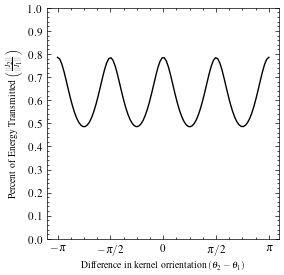

In [8]:
fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=7)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=7)

plt.savefig('malus2_saddle.pdf', dpi=600)
plt.show()


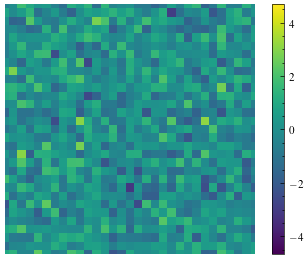

In [9]:
i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

fig, ax= plt.subplots(1,1)


im =ax.imshow(i0[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i0_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)


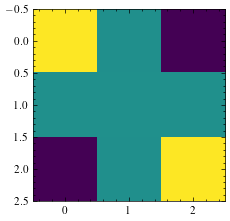

In [10]:

w[:,:,0,0] = (np.cos(2*angle))*w1 + ( np.sin(2*angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))
plt.imshow(w[:,:,0,0])

tf.Tensor(502.11243, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=355.37482>

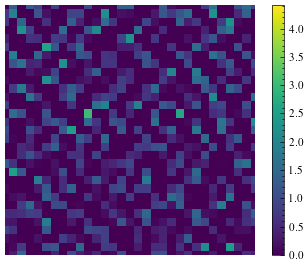

In [11]:
angle = -np.pi

w = np.zeros((3,3,1,1))

w[:,:,0,0] = (np.cos(2*angle))*w1 + ( np.sin(2*angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

print((tf.math.reduce_euclidean_norm(i0)))

i1_x = tf.nn.relu( tf.nn.conv2d(i0, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i1[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');




ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i1)



<tf.Tensor: shape=(), dtype=float32, numpy=279.22592>

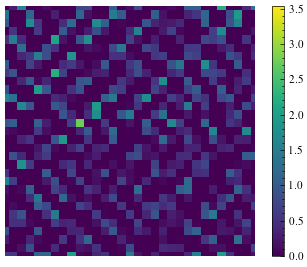

In [12]:
angle = -np.pi

w[:,:,0,0] = (np.cos(2*angle))*w1 + ( np.sin(2*angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))




i2_x = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_x[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i2_y_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i2_x)

<tf.Tensor: shape=(), dtype=float32, numpy=172.39558>

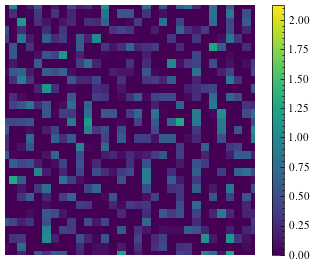

In [13]:
angle = np.pi/4

w[:,:,0,0] = (np.cos(2*angle))*w1 + ( np.sin(2*angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))




i2_y = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2_y[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig("i2_y_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i2_y)

In [14]:
i0.shape

TensorShape([1, 520, 520, 1])

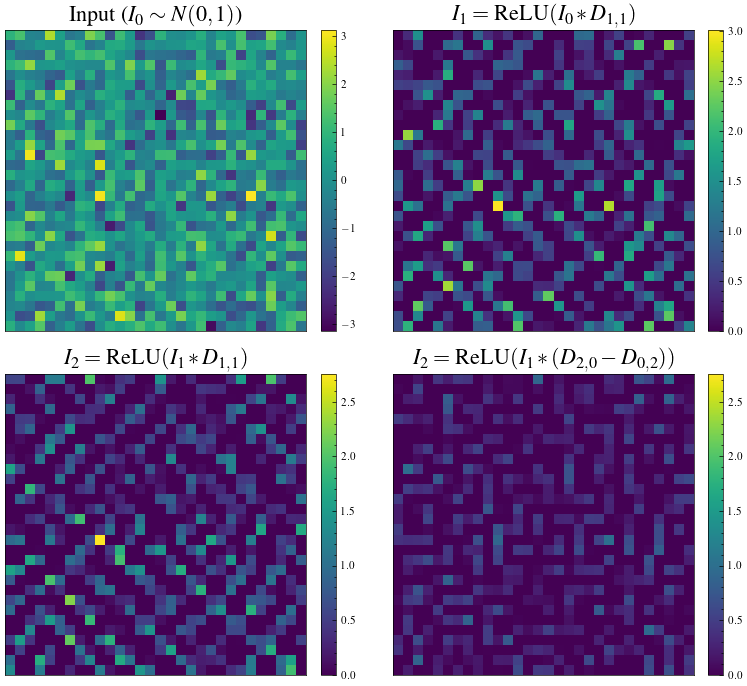

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
title_fontsize = 16  # Adjust as needed

# Top-left
im0 = axs[0, 0].imshow(i0[0, 30:60, 30:60, 0].numpy(), cmap='viridis')
axs[0, 0].set_title(r'Input ($I_0 \sim N(0, 1)$)', fontsize=title_fontsize)
fig.colorbar(im0, ax=axs[0, 0], fraction=0.046, pad=0.04)
#ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));



#fig.colorbar(im, orientation='vertical');


# Top-right
im1 = axs[0, 1].imshow(i1_x[0, 30:60, 30:60, 0].numpy(), cmap='viridis')
axs[0, 1].set_title(r'$I_1 = \mathrm{ReLU}(I_0 * D_{1,1})$', fontsize=title_fontsize)
fig.colorbar(im1, ax=axs[0, 1], fraction=0.046, pad=0.04)

# Bottom-left
im2 = axs[1, 0].imshow(i2_x[0, 30:60, 30:60, 0].numpy(), cmap='viridis')
axs[1, 0].set_title(r'$I_2 = \mathrm{ReLU}(I_1 *  D_{1,1})$', fontsize=title_fontsize)
fig.colorbar(im2, ax=axs[1, 0], fraction=0.046, pad=0.04)

vmin = i2_x[0,...,0].numpy().min()
vmax = i2_x[0,...,0].numpy().max()


# Bottom-right
im3 = axs[1, 1].imshow(
    i2_y[0, 30:60, 30:60, 0].numpy(), 
    cmap='viridis', 
    vmin=vmin, 
    vmax=vmax
)
axs[1, 1].set_title(r'$I_2 = \mathrm{ReLU}(I_1 * (D_{2,0}-D_{0,2}))$', fontsize=title_fontsize)
fig.colorbar(im2, ax=axs[1, 1], fraction=0.046, pad=0.04)

# Optional: tighten layout and remove axis ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.savefig("malus_saddle_random.pdf", dpi=600)

plt.show()




In [16]:
np.max(i1_x), np.max(i2_x)

(4.4190288, 3.5386577)

In [17]:
np.sum(w)

5.390061641723897e-18

In [18]:
np.max(tf.nn.conv2d(i0, w , strides=(1,1), padding='SAME'))

4.7657413

In [19]:
np.max(tf.nn.conv2d(i1, w , strides=(1,1), padding='SAME'))

2.1294622

/tmp/ipykernel_7799/3595508972.py:34: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


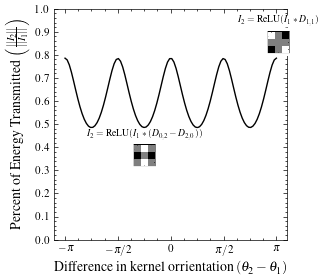

In [20]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea, VPacker
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def render_patch_with_border(patch, border_color='black', border_width=1, zoom=1.0):
	"""
	Renders a patch using imshow-style with a border and returns it as an OffsetImage.
	"""
	# Create a tiny figure to render the patch using imshow
	fig, ax = plt.subplots(figsize=(1, 1), dpi=100)
	canvas = FigureCanvas(fig)

	ax.imshow(patch, cmap='gray', interpolation='none')
	ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


	for spine in ax.spines.values():
		spine.set_visible(True)
		spine.set_linewidth(1)
		spine.set_color('black')

	# Make sure spines are drawn on top of the image
	ax.set_frame_on(True)
	# Add rectangle border
	'''h, w = patch.shape
	ax.add_patch(plt.Rectangle(
		(-0.5, -0.5), w, h,
		edgecolor=border_color,
		facecolor='none',
		linewidth=border_width
	))'''

	# Render to array
	canvas.draw()
	img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
	img = img.reshape(canvas.get_width_height()[::-1] + (3,))

	plt.close(fig)
	return OffsetImage(img, zoom=zoom)

# Function to place image on the curve

def add_patch_with_label(ax, x, y, patch, label):
	# Create rendered image with border
	imagebox = render_patch_with_border(patch, border_color='black', border_width=2, zoom=0.2)

	# Create label
	textbox = TextArea(label, textprops={
		'fontsize': 7,
		'ha': 'center',
		'va': 'center',
		'bbox': dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
	})

	# Stack vertically
	vpack = VPacker(children=[textbox, imagebox], align="center", pad=0, sep=3)
	ab = AnnotationBbox(vpack, (x, y), frameon=False, box_alignment=(0.5, 0.5))

	ax.add_artist(ab)


fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=10)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=10)

# Locations along curve
x1, y1 = -np.pi/4, response_mag[len(response_mag)//8]  # for dy
x2, y2 = np.pi, response_mag[-1]     # for dx
w[:,:,0,0] = (np.cos(2*np.pi))*w1 + ( np.sin(2*np.pi))*w2
dx_kernel = w[:,:,0,0]
add_patch_with_label(ax, x2+0.05, y2+0.1, dx_kernel, r'$I_2 = \mathrm{ReLU}(I_1 * D_{1,1})$')



w[:,:,0,0] = (np.cos(2*np.pi/4))*w1 + ( np.sin(2*np.pi/4))*w2

dy_kernel = w[:,:,0,0]

add_patch_with_label(ax, x1,  y1-0.09, dy_kernel, r'$I_2 = \mathrm{ReLU}(I_1 * (D_{0,2} - D_{2,0}))$')


plt.savefig('malus_curve_random_saddle.pdf', dpi=600)
plt.show()


In [21]:
response_mag

[0.7857223,
 0.7781899,
 0.75666887,
 0.72481,
 0.68711776,
 0.6477183,
 0.6097544,
 0.5753241,
 0.5456921,
 0.52157634,
 0.50339085,
 0.4913594,
 0.4856235,
 0.48624068,
 0.49322036,
 0.50651944,
 0.52599514,
 0.5513885,
 0.58220655,
 0.61760116,
 0.65610087,
 0.6953753,
 0.7320249,
 0.76175064,
 0.7801215,
 0.783944,
 0.77250326,
 0.74788684,
 0.7141012,
 0.6756506,
 0.6364426,
 0.59932745,
 0.56617737,
 0.5381131,
 0.5157679,
 0.499464,
 0.48935777,
 0.48550716,
 0.48793346,
 0.49660864,
 0.5114646,
 0.53237563,
 0.55907667,
 0.59106374,
 0.62737817,
 0.66638714,
 0.70548517,
 0.74100214,
 0.7684959,
 0.7836887,
 0.78385824,
 0.7689873,
 0.7417533,
 0.7064152,
 0.66741,
 0.6284019,
 0.59200406,
 0.5598532,
 0.5329133,
 0.5117263,
 0.4965947,
 0.48769927,
 0.4851364,
 0.48893622,
 0.49908665,
 0.5154971,
 0.5379759,
 0.5661618,
 0.59940654,
 0.6365852,
 0.67582864,
 0.7142811,
 0.7480415,
 0.77260154,
 0.7839636,
 0.7800612,
 0.76162076,
 0.73185384,
 0.6951927,
 0.655937,
 0.6174874

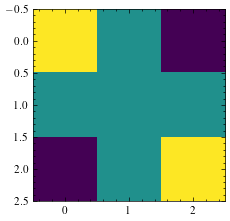

In [22]:
plt.imshow((np.cos(2*np.pi/4))*w2 + ( np.sin(2*np.pi/4))*w1)

In [23]:
a = np.pi
w[:,:,0,0] = (np.cos(a))*w1 + ( np.sin(a))*w2

print((tf.math.reduce_euclidean_norm(w)))

w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))
print((tf.math.reduce_euclidean_norm(w)))



tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)


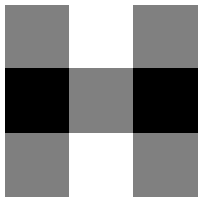

In [24]:
w[:,:,0,0] = (np.cos(np.pi/2))*w1 + ( np.sin(np.pi/2))*w2





p = plt.imshow(w[:,:,0,0], cmap='gray')
plt.axis('off')
p


array([[[[ 0.13608276]],

        [[ 0.        ]],

        [[-0.13608276]]],


       [[[ 0.13608276]],

        [[ 0.        ]],

        [[-0.13608276]]],


       [[[ 0.13608276]],

        [[ 0.        ]],

        [[-0.13608276]]]])

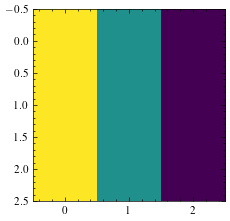

In [25]:
a = np.zeros((3,3))
a[0, 1] =1
a = np.reshape(fft.idctn(a, norm='ortho'), (3,3,1,1))

b = np.zeros((3,3))
b[0, 0] =1
b = np.reshape(fft.idctn(b, norm='ortho'), (3,3,1,1))

dct_basis = a*b

plt.imshow(dct_basis[..., 0,0])
dct_basis